# Taller 1 - Datos funcionales

## Librerías

In [23]:
import os
import warnings
import numpy as np
import scipy.io as sio
import pandas as pd
import matplotlib.pyplot as plt
import skfda
from skfda.representation.basis import BSplineBasis
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.exploratory.stats import mean, trim_mean, cov, depth_based_median
from skfda.exploratory.depth import ModifiedBandDepth, BandDepth
from tqdm import tqdm
from skfda.exploratory.visualization import Boxplot

# Suppress warnings
warnings.filterwarnings("ignore")


## Cargar los datos

In [22]:
# Load MATLAB data
archivo_mat = "../Datos/data.mat"
datos = sio.loadmat(archivo_mat)

# Reshape data 
# Dimensions: 268 tests x 571 measurement points x 7 wavelengths
data = datos["X"].reshape(268, 571, 7, order='F')

# Wavelength labels
wavelengths = {
    0: 'Y1=230', 1: 'Y2=240', 2: 'Y3=255', 
    3: 'Y4=290', 4: 'Y5=305', 5: 'Y6=325', 6: 'Y7=340'
}

# Measurement points grid
dominio = np.arange(275, 560.5, 0.5)

# longitud de onda a trabajar
wavelength_idx = 6

## Visualization of Raw Data

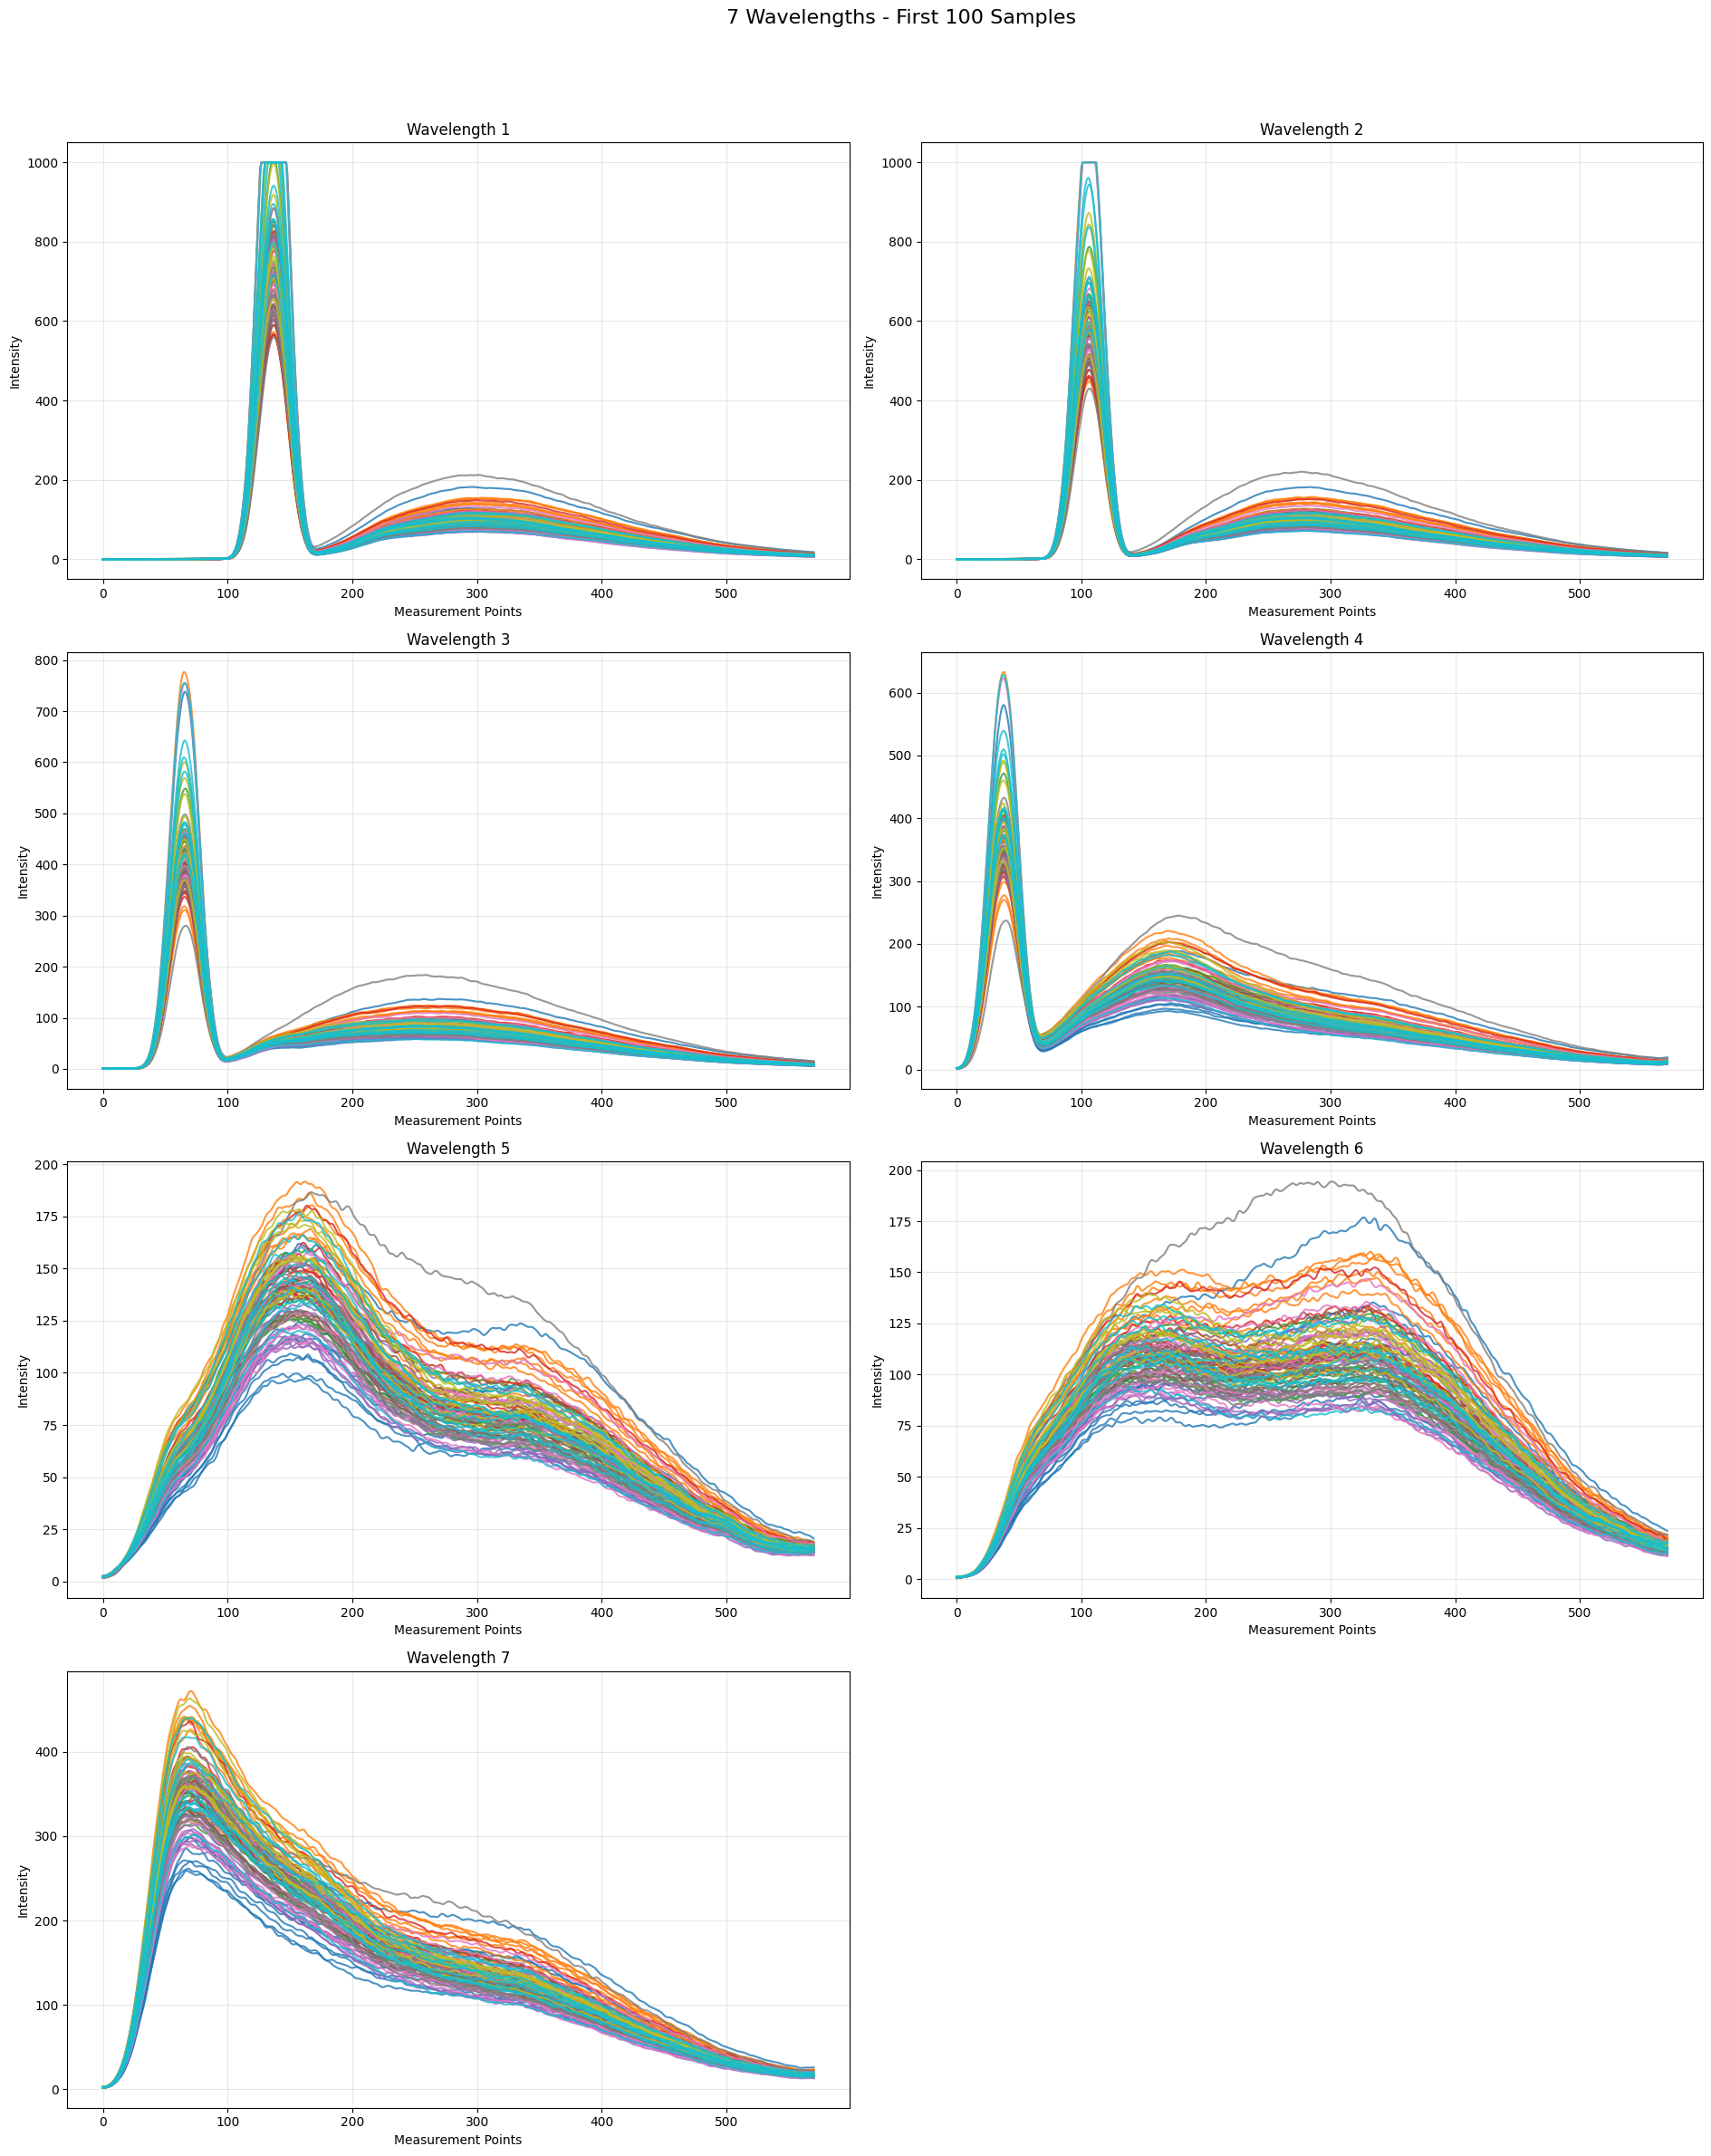

In [11]:
def plot_wavelength_data(organizado, n_samples=100):
    """
    Plot intensity data for first n_samples across 7 wavelengths
    """
    colors = plt.cm.tab10(np.linspace(0, 1, n_samples))
    fig, axes = plt.subplots(4, 2, figsize=(20, 25))
    fig.suptitle('7 Wavelengths - First 100 Samples', fontsize=16)
    
    axes = axes.ravel()
    x = np.arange(571)
    
    for wavelength in range(7):
        for sample in range(n_samples):
            data = organizado[sample, :, wavelength]
            axes[wavelength].plot(x, data, color=colors[sample], 
                                   linewidth=1.5, alpha=0.8)
        
        axes[wavelength].set_title(f'Wavelength {wavelength+1}', fontsize=12)
        axes[wavelength].set_xlabel('Measurement Points')
        axes[wavelength].set_ylabel('Intensity')
        axes[wavelength].grid(True, alpha=0.3)
    
    axes[-1].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 0.95, 0.95])
    plt.show()

plot_wavelength_data(data)

## 1.1 Suavizado spline

'Hay un total de 1876 curvas a procesar'

Procesando muestras:   0%|          | 0/1876 [00:00<?, ?it/s]

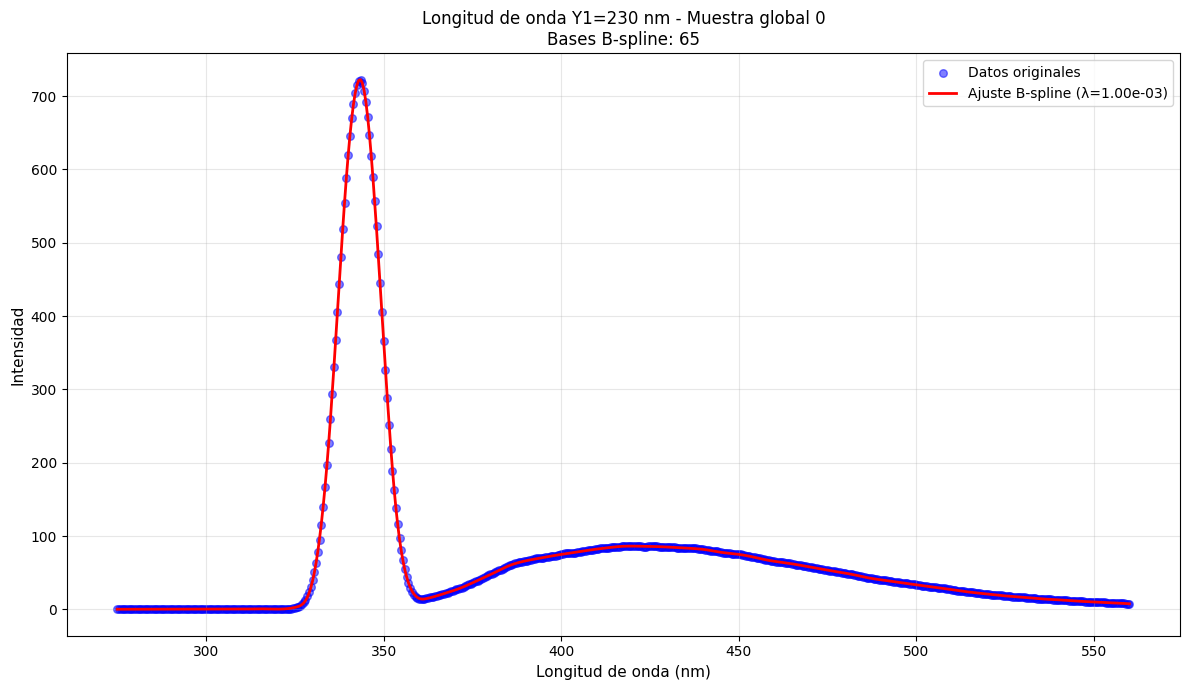

Procesando muestras:   5%|▌         | 100/1876 [02:45<47:09,  1.59s/it] 

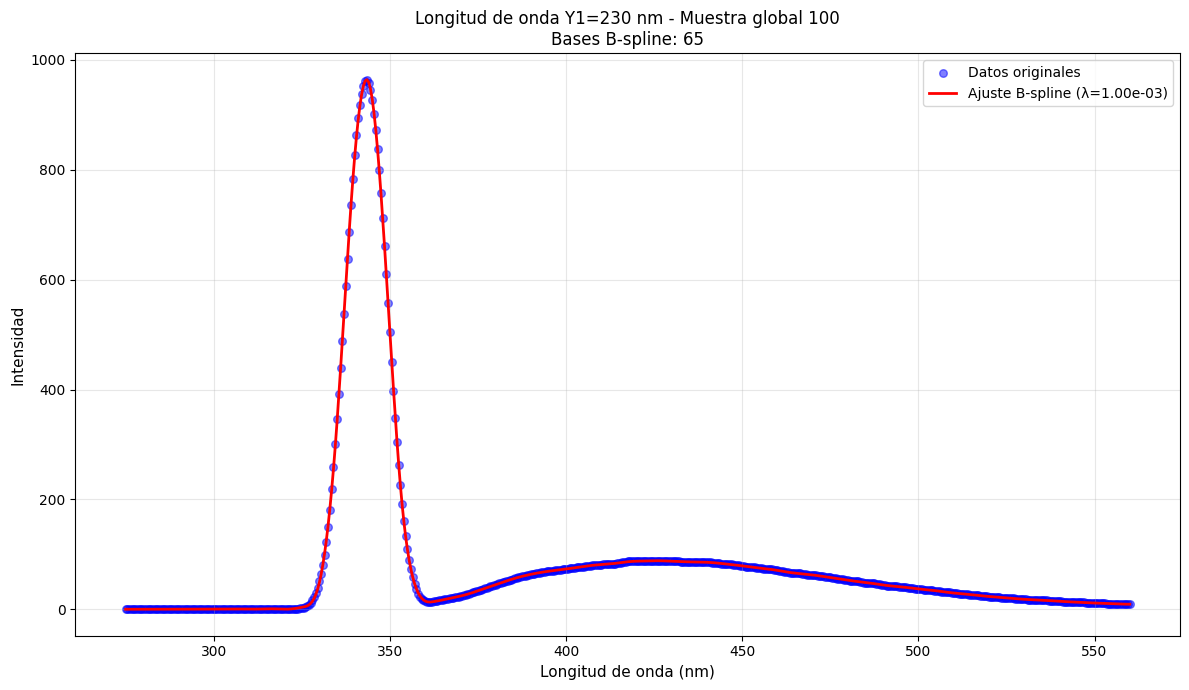

Procesando muestras:  11%|█         | 200/1876 [05:30<43:06,  1.54s/it]

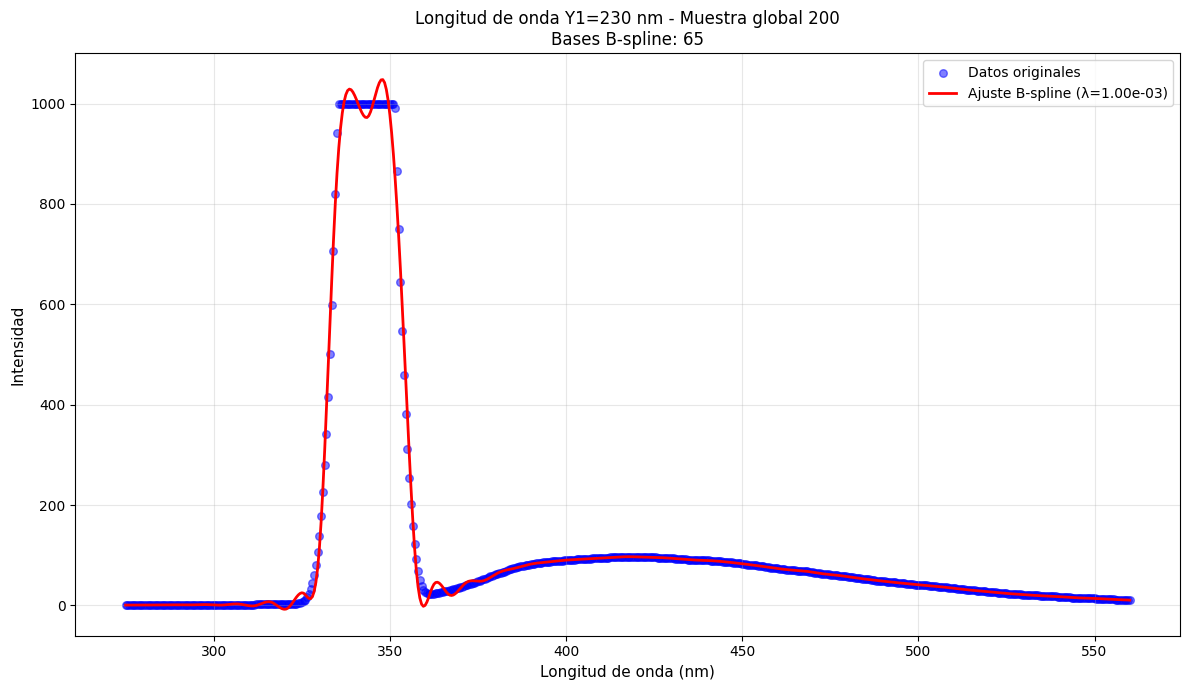

Procesando muestras:  16%|█▌        | 300/1876 [08:09<48:03,  1.83s/it]

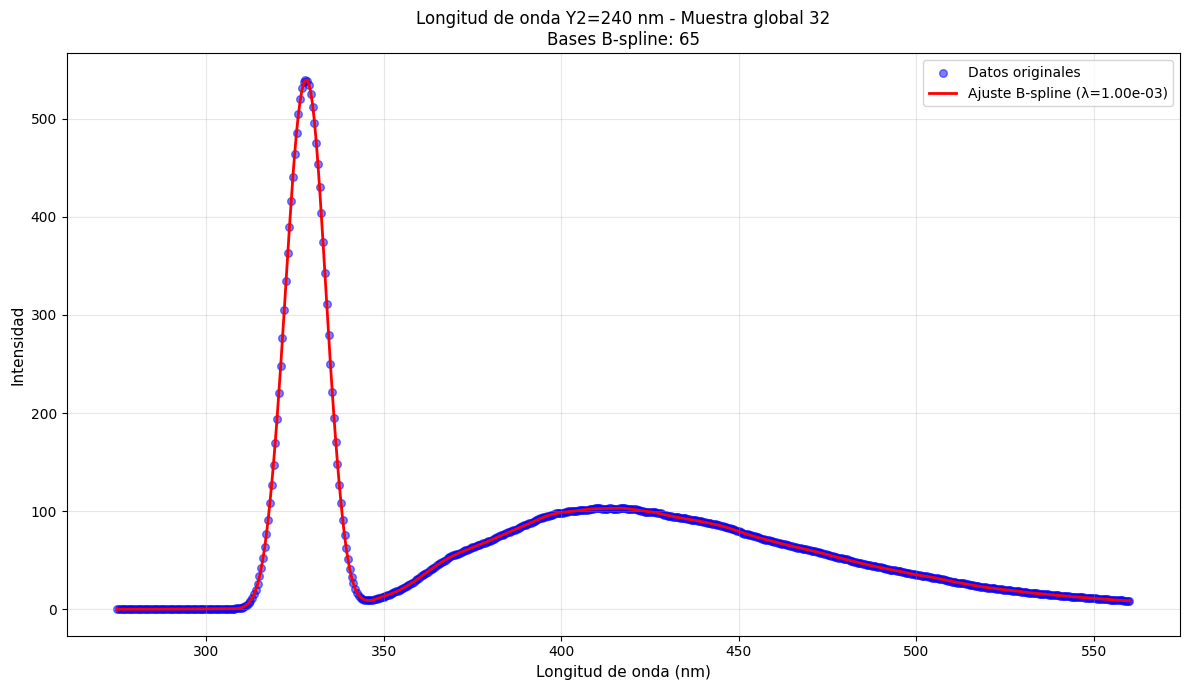

Procesando muestras:  21%|██▏       | 400/1876 [10:47<42:16,  1.72s/it]

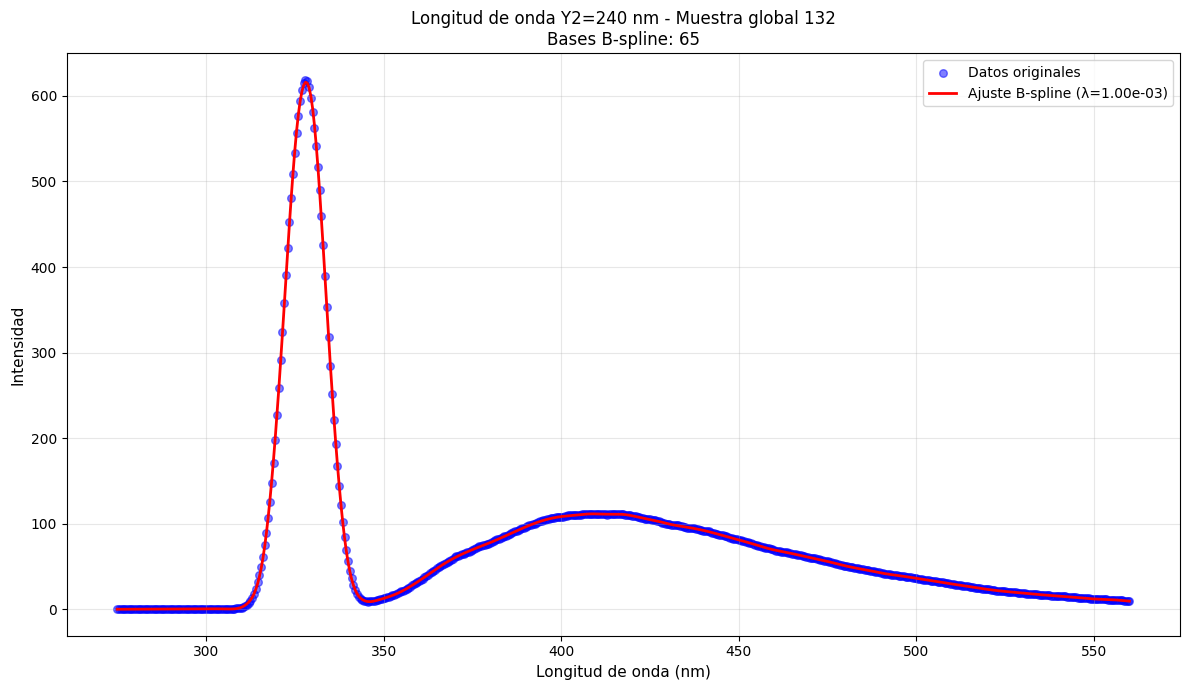

Procesando muestras:  27%|██▋       | 500/1876 [13:14<30:30,  1.33s/it]

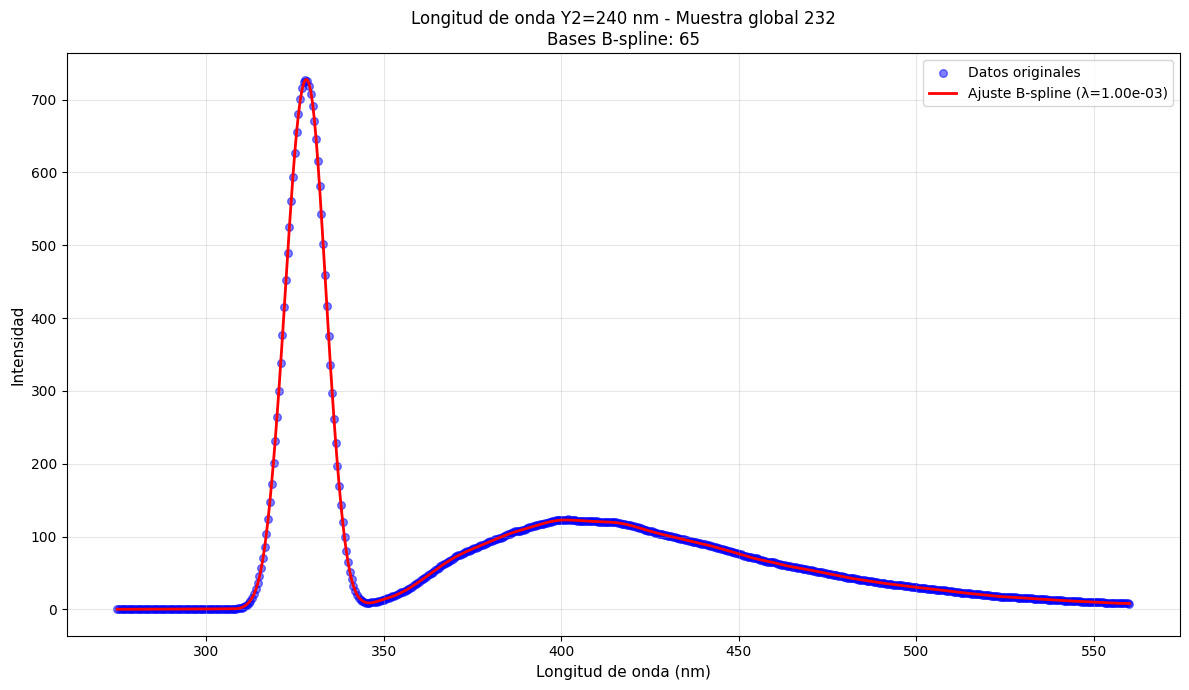

Procesando muestras:  32%|███▏      | 600/1876 [15:31<28:49,  1.36s/it]

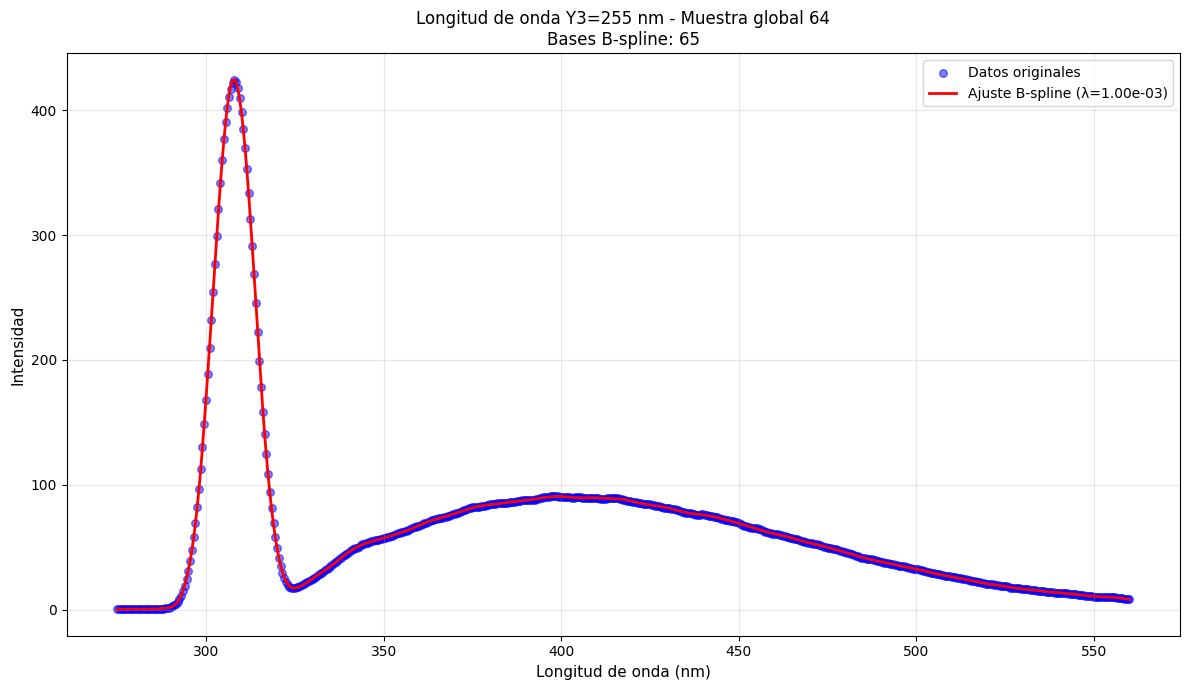

Procesando muestras:  37%|███▋      | 700/1876 [17:48<27:32,  1.41s/it]

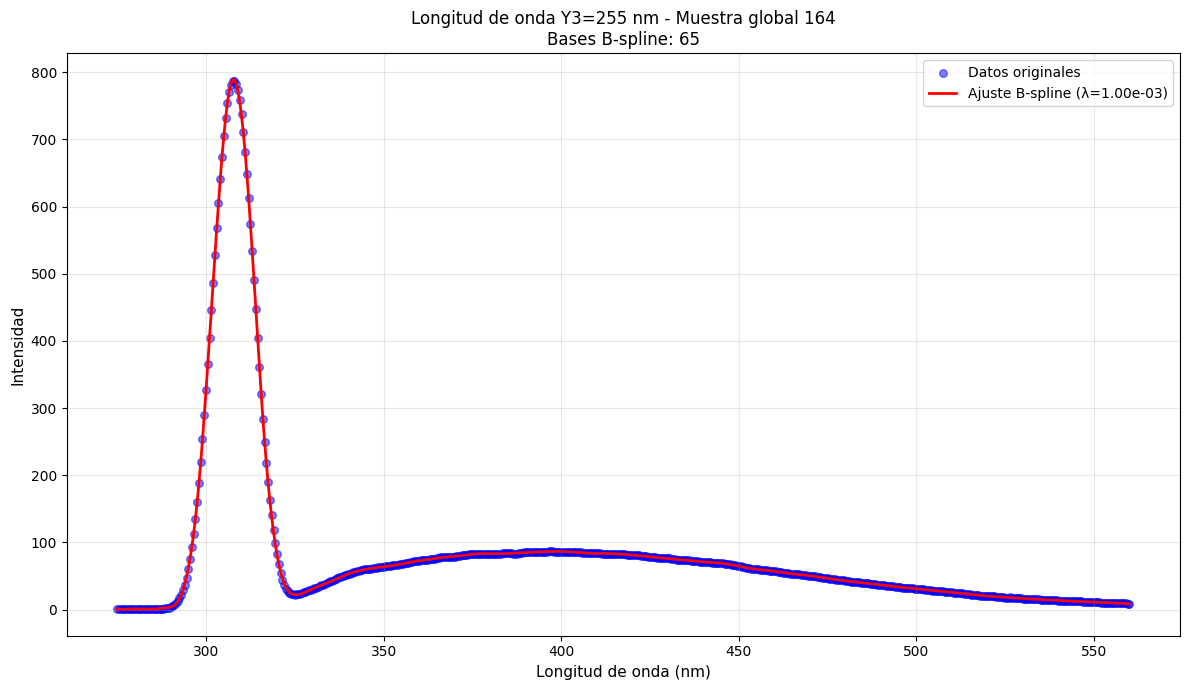

Procesando muestras:  43%|████▎     | 800/1876 [20:05<24:27,  1.36s/it]

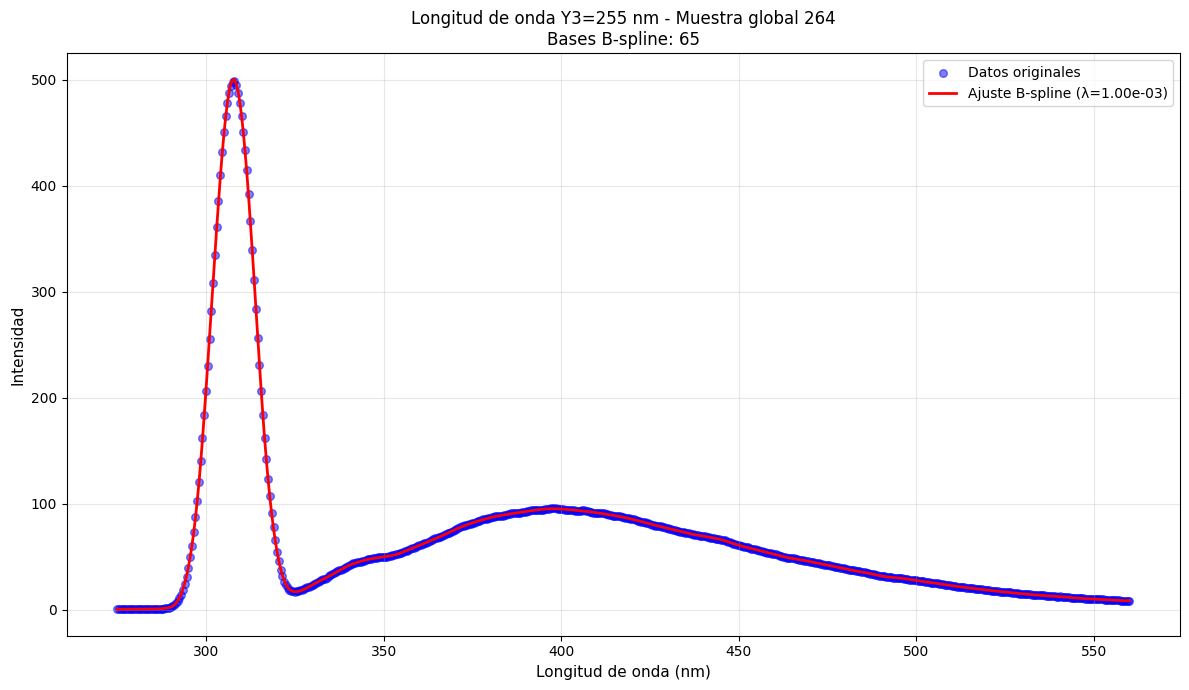

Procesando muestras:  48%|████▊     | 900/1876 [22:23<21:45,  1.34s/it]

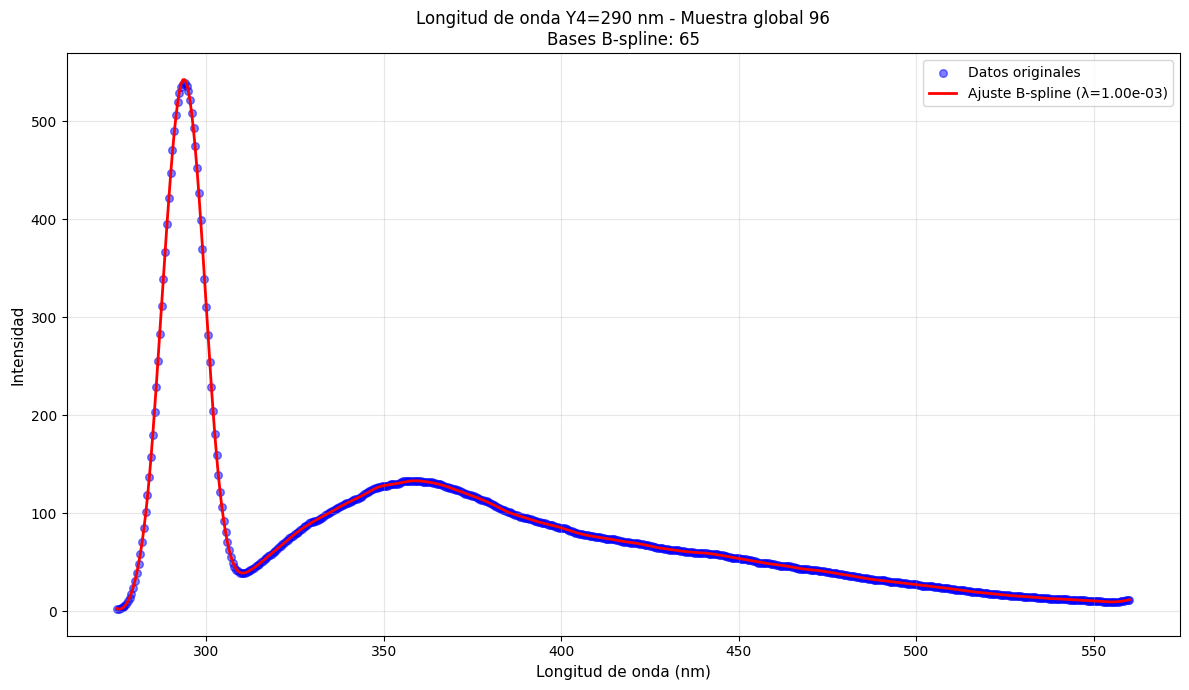

Procesando muestras:  53%|█████▎    | 1000/1876 [24:40<19:49,  1.36s/it]

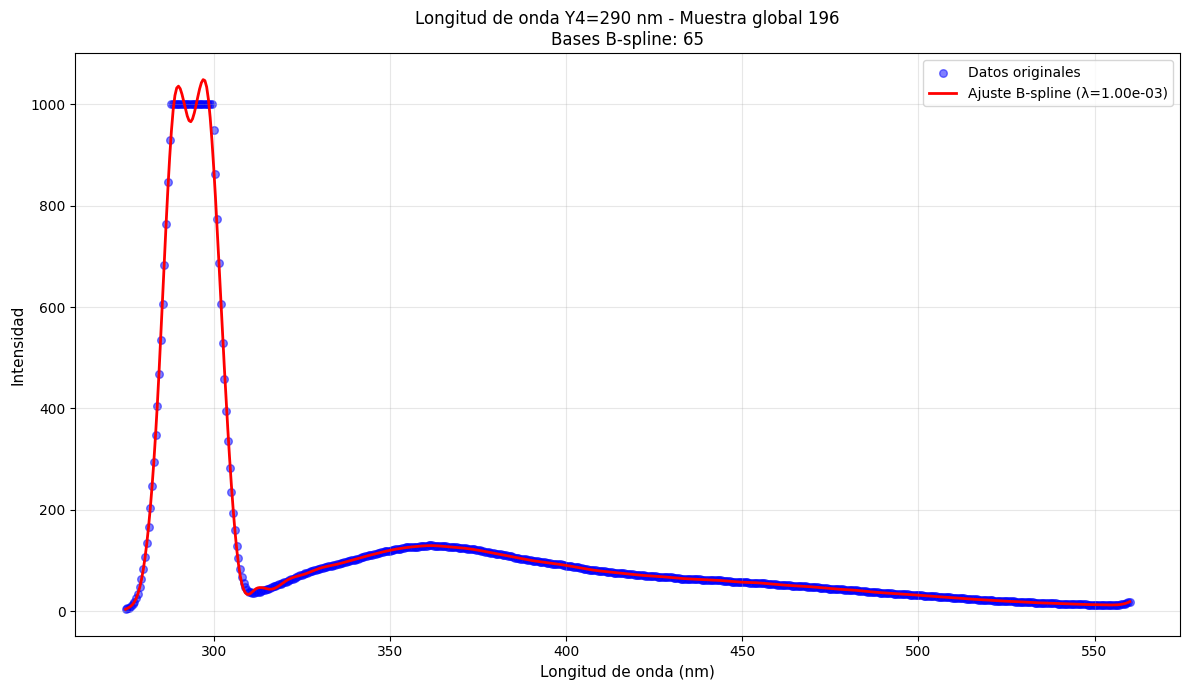

Procesando muestras:  59%|█████▊    | 1100/1876 [26:58<18:06,  1.40s/it]

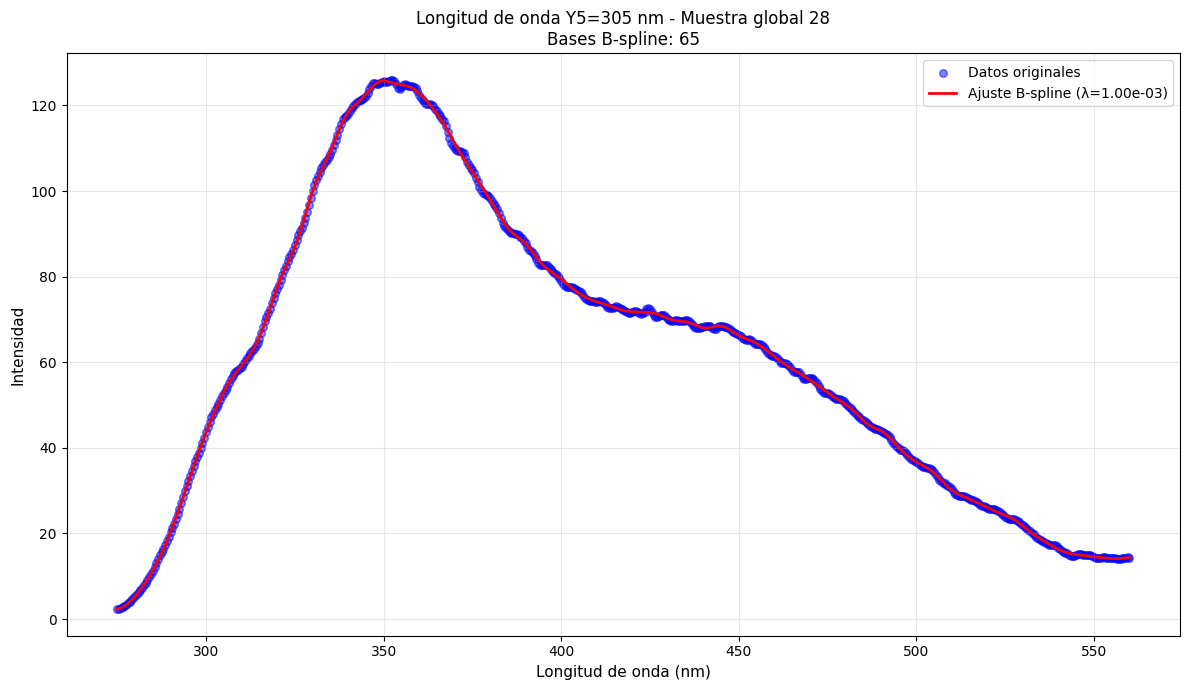

Procesando muestras:  64%|██████▍   | 1200/1876 [29:30<17:30,  1.55s/it]

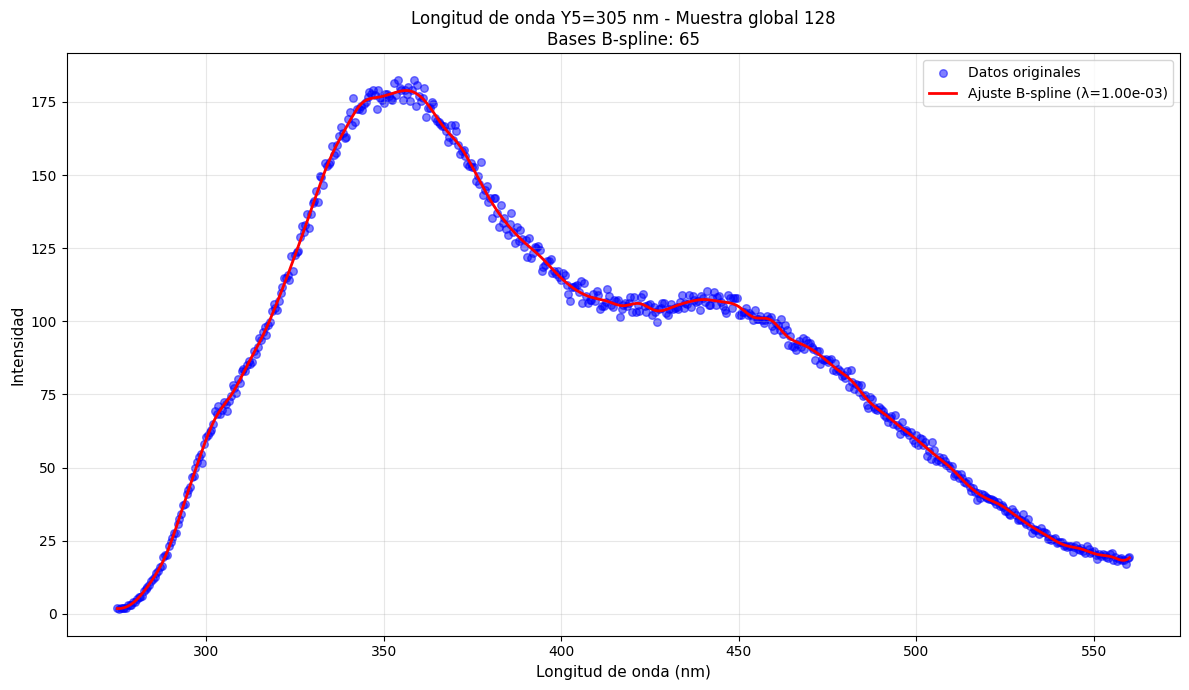

Procesando muestras:  69%|██████▉   | 1300/1876 [32:08<13:25,  1.40s/it]

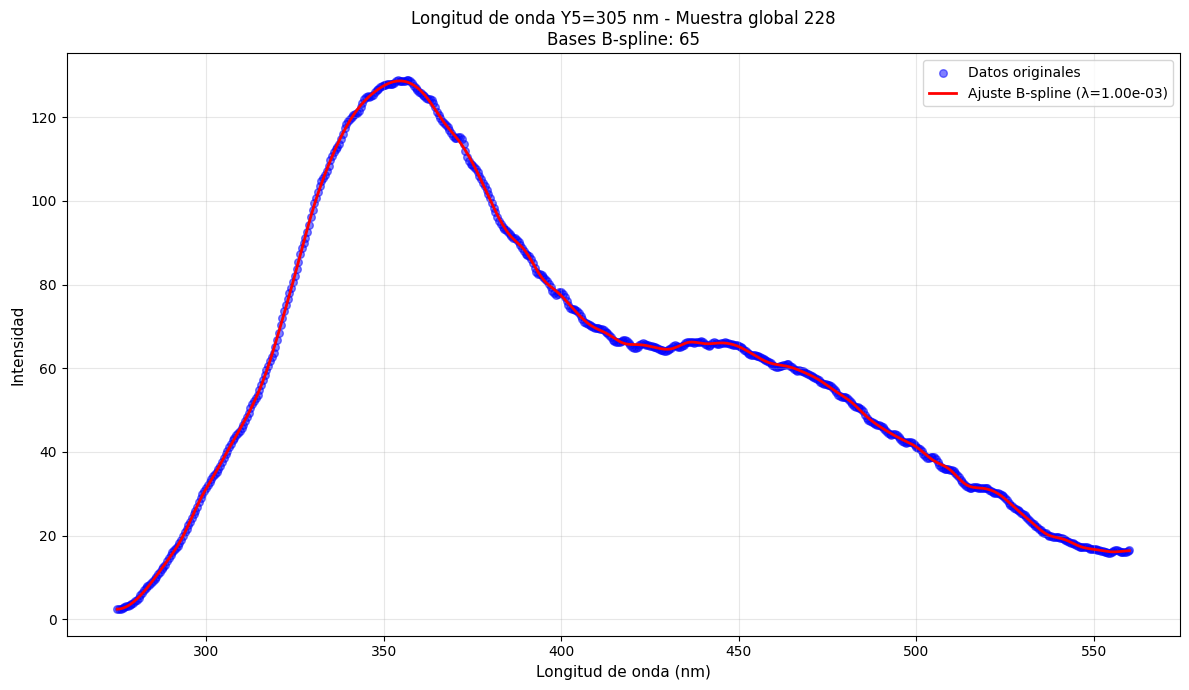

Procesando muestras:  75%|███████▍  | 1400/1876 [34:27<11:07,  1.40s/it]

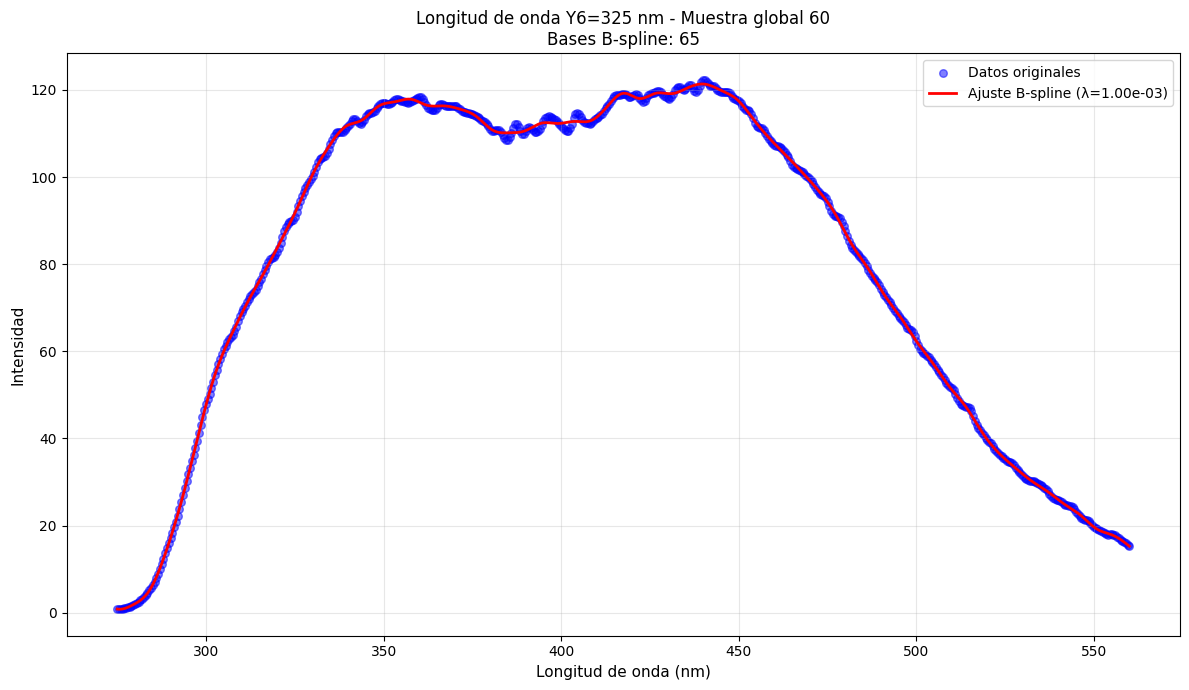

Procesando muestras:  80%|███████▉  | 1500/1876 [36:46<08:24,  1.34s/it]

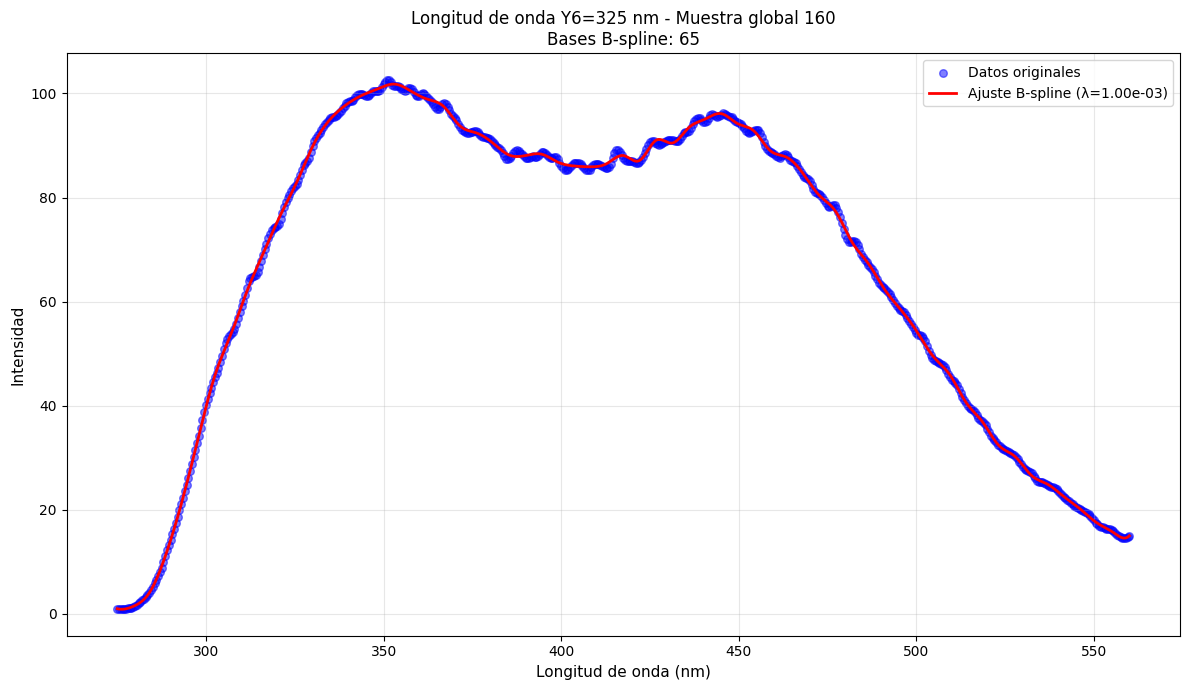

Procesando muestras:  85%|████████▌ | 1600/1876 [39:06<06:25,  1.39s/it]

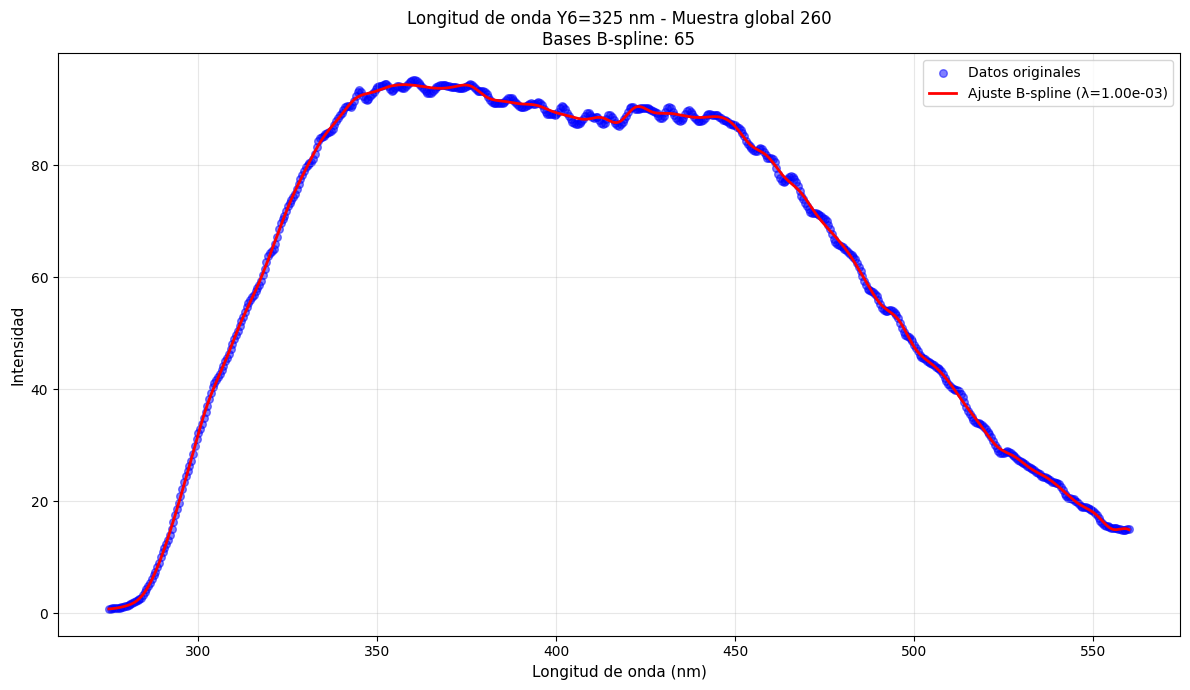

Procesando muestras:  91%|█████████ | 1700/1876 [41:26<04:06,  1.40s/it]

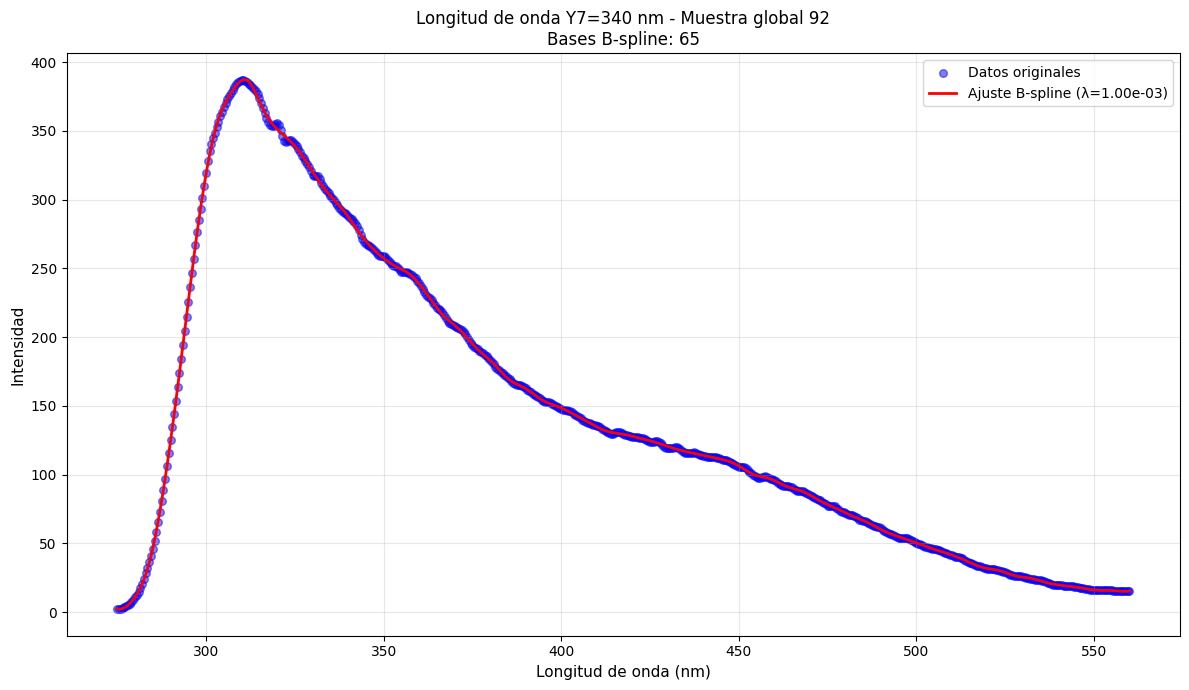

Procesando muestras:  96%|█████████▌| 1800/1876 [43:46<01:45,  1.39s/it]

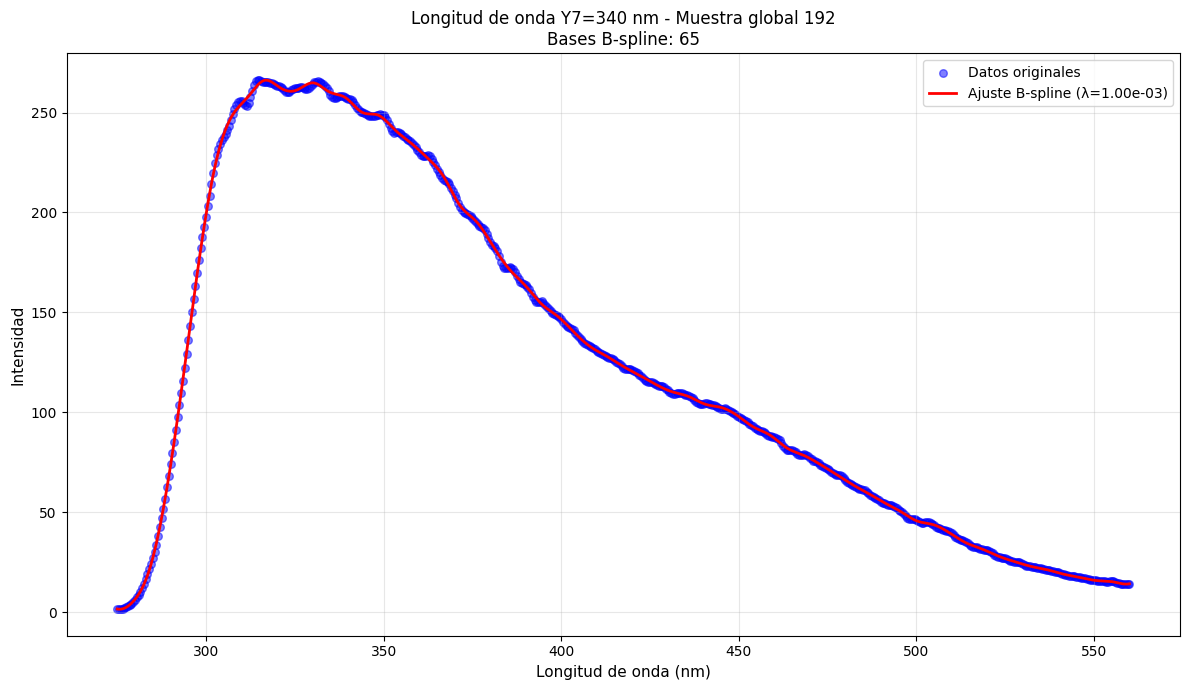

Procesando muestras: 100%|██████████| 1876/1876 [45:32<00:00,  1.46s/it]

Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.


In [ ]:
def smooth_functional_data(
    data, 
    wavelengths, 
    dominio, 
    base_path="../Resultados/punto_1", 
    n_basis=65, 
    best_param=1e-3, 
    rango_curvas=[None, None],
    mostrar_imagen_cada=None  
):
    """
    Perform functional data smoothing for specified range of samples and wavelengths
    
    Parameters:
    -----------
    data : numpy.ndarray
        Input data array with dimensions (n_samples, n_points, n_wavelengths)
    wavelengths : dict
        Dictionary of wavelengths
    dominio : array-like
        Domain points for the data
    base_path : str, optional
        Base directory to save results
    n_basis : int, optional
        Number of B-Spline basis functions
    best_param : float, optional
        Smoothing parameter (lambda)
    rango_curvas : list, optional
        Range of curves to process [start, end]. 
        If None, processes all curves. 
        Indices are 0-based.
    mostrar_imagen_cada : int or None, optional
        Show an image every 'n' processed samples.
        If None, no images are shown during processing.
    """
    # Crear la estructura de carpetas base
    if not os.path.exists(base_path):
        os.makedirs(base_path)

    # Crear subcarpetas para cada longitud de onda
    for wave_idx, wave_name in wavelengths.items():
        wave_path = os.path.join(base_path, wave_name)
        if not os.path.exists(wave_path):
            os.makedirs(wave_path)

    # Determinar el rango de curvas a procesar
    inicio = rango_curvas[0] if rango_curvas[0] is not None else 0
    fin = rango_curvas[1] if rango_curvas[1] is not None else 5  

    # Crear una barra de progreso
    total_iterations = fin - inicio
    with tqdm(total=total_iterations, desc="Procesando muestras") as pbar:
        # Contador de muestras procesadas
        muestras_procesadas = 0

        # Para cada longitud de onda
        for wave_idx, wave_name in wavelengths.items():
            # Si ya hemos procesado todas las muestras requeridas, salir del bucle
            if muestras_procesadas >= fin:
                break

            # Procesar muestras para esta longitud de onda
            for muestra in range(data.shape[0]):
                # Si ya hemos procesado todas las muestras requeridas, salir del bucle
                if muestras_procesadas >= fin:
                    break

                # Obtener los datos para esta muestra y longitud de onda
                X = data[muestra, :, wave_idx].flatten()
                
                # Crear una base B-Spline
                basis = BSplineBasis(domain_range=(275, 560), n_basis=n_basis)
                
                # Crear functional data grid
                fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
                
                # Suavizado penalizado
                smoother = BasisSmoother(basis, smoothing_parameter=best_param)
                fd_smoothed = smoother.fit_transform(fd)
                
                # Decidir si mostrar la imagen
                if mostrar_imagen_cada is not None and muestras_procesadas % mostrar_imagen_cada == 0:
                    # Crear la figura
                    plt.figure(figsize=(12, 7))
                    
                    # Graficar los datos originales como puntos
                    plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                    
                    # Graficar la curva ajustada
                    plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                             label=f'Ajuste B-spline (λ={best_param:.2e})',
                             linewidth=2)
                    
                    # Personalización del gráfico
                    plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                              f'Bases B-spline: {n_basis}', fontsize=12)
                    plt.xlabel('Longitud de onda (nm)', fontsize=11)
                    plt.ylabel('Intensidad', fontsize=11)
                    plt.legend(fontsize=10)
                    plt.grid(True, alpha=0.3)
                    
                    # Ajustar los márgenes
                    plt.tight_layout()
                    
                    # Mostrar la figura
                    plt.show()
                
                # Crear la figura para guardar
                plt.figure(figsize=(12, 7))
                
                # Graficar los datos originales como puntos
                plt.scatter(dominio, X, c='blue', s=30, alpha=0.5, label='Datos originales')
                
                # Graficar la curva ajustada
                plt.plot(dominio, fd_smoothed(dominio)[0], 'r-',
                         label=f'Ajuste B-spline',
                         linewidth=2)
                
                # Personalización del gráfico
                plt.title(f'Longitud de onda {wave_name} nm - Muestra global {muestra}\n'
                          f'Bases B-spline: {n_basis}', fontsize=12)
                plt.xlabel('Longitud de onda (nm)', fontsize=11)
                plt.ylabel('Intensidad', fontsize=11)
                plt.legend(fontsize=10)
                plt.grid(True, alpha=0.3)
                
                # Ajustar los márgenes
                plt.tight_layout()
                
                # Guardar la figura
                output_path = os.path.join(
                    base_path,
                    wave_name,
                    f'onda_{wave_idx}_muestra_global_{muestra}.png'
                )
                plt.savefig(output_path, dpi=300, bbox_inches='tight')
                plt.close()
                
                # Incrementar el contador de muestras procesadas
                muestras_procesadas += 1
                
                # Actualizar la barra de progreso
                pbar.update(1)

    print("Proceso completado. Se han generado todas las imágenes con el ajuste penalizado.")

total_curvas = 7*268
print(f'Hay un total de {total_curvas} curvas a procesar')
smooth_functional_data(data, wavelengths, dominio, rango_curvas=[0, total_curvas], mostrar_imagen_cada=100)


## 1.2 

### Estadistica descriptiva funcional

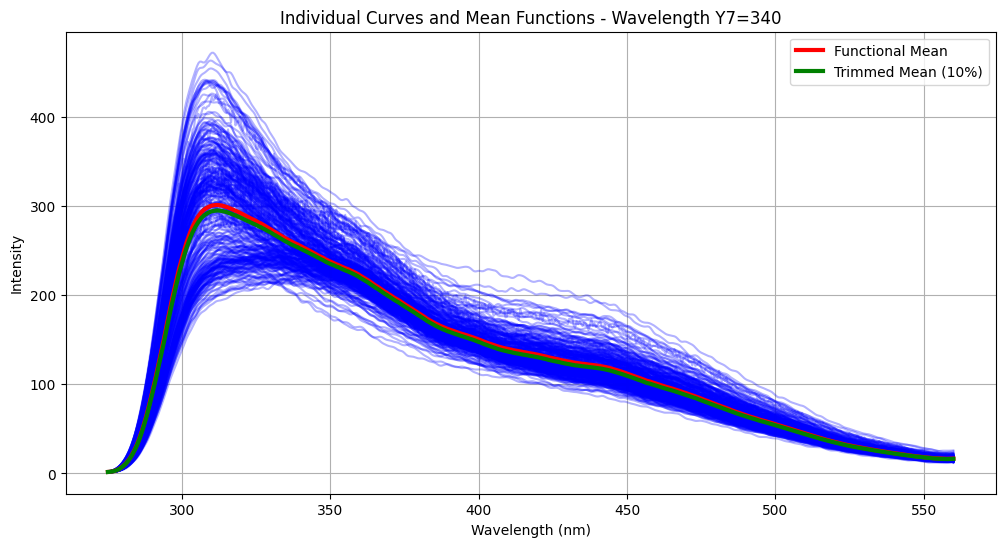

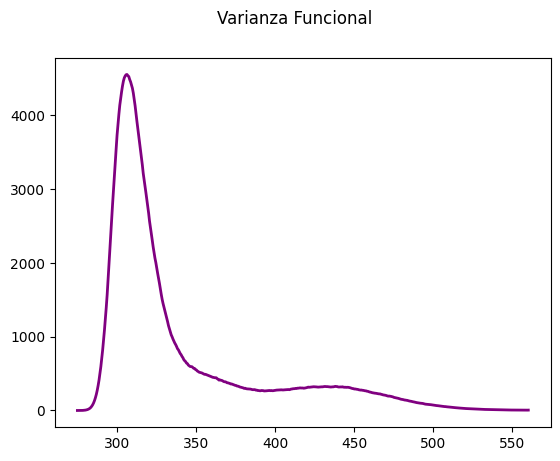

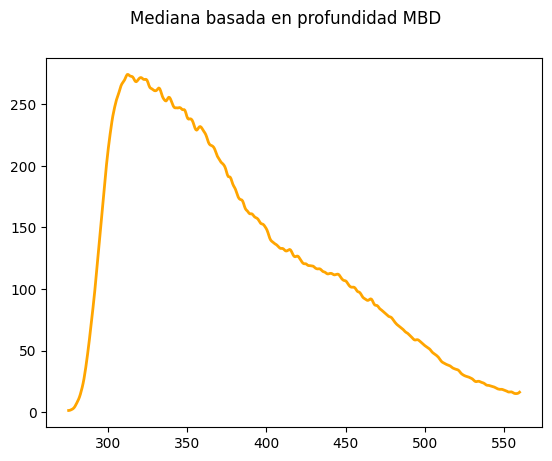

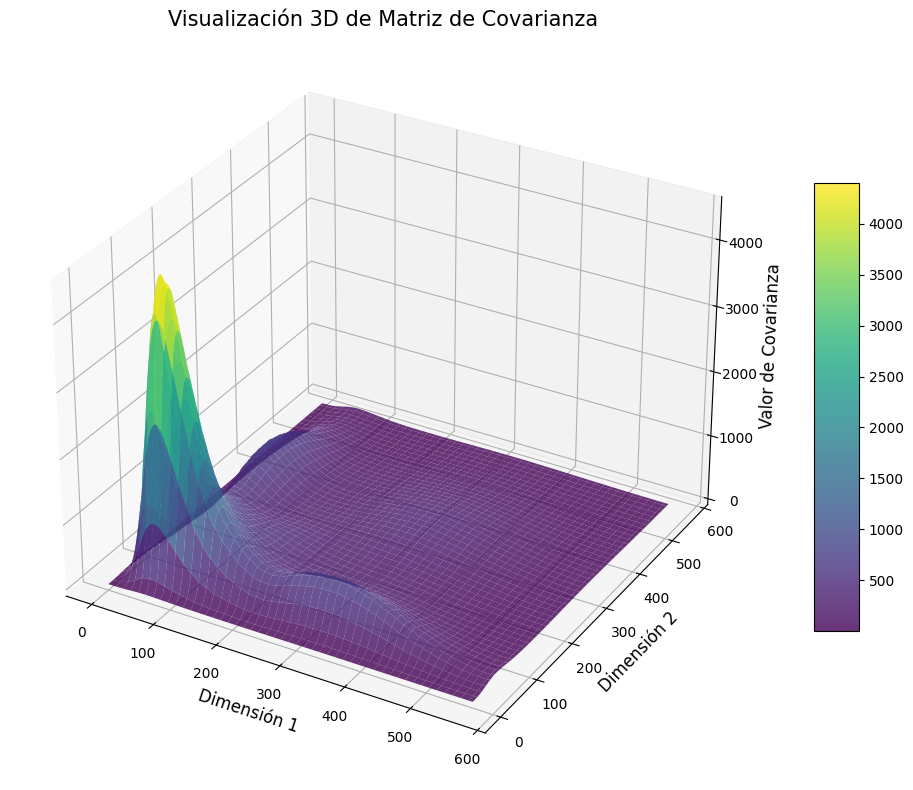

In [46]:
def plot_covariance_3d(cov_matrix):
    """
    Visualiza una matriz de covarianza en un gráfico 3D de superficie.
    
    Parámetros:
    cov_matrix (numpy.ndarray): Matriz de covarianza a visualizar
    """
    # Crear coordenadas para la malla
    x = np.arange(cov_matrix.shape[0])
    y = np.arange(cov_matrix.shape[1])
    X, Y = np.meshgrid(x, y)
    
    # Crear figura y eje 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    
    # Graficar la superficie de la matriz de covarianza
    surf = ax.plot_surface(X, Y, cov_matrix, 
                           cmap='viridis',  # Puedes cambiar el colormap
                           edgecolor='none',
                           alpha=0.8)
    
    # Personalizar el gráfico
    ax.set_title('Visualización 3D de Matriz de Covarianza', fontsize=15)
    ax.set_xlabel('Dimensión 1', fontsize=12)
    ax.set_ylabel('Dimensión 2', fontsize=12)
    ax.set_zlabel('Valor de Covarianza', fontsize=12)
    
    # Añadir una barra de color
    fig.colorbar(surf, shrink=0.6, aspect=10)
    
    plt.tight_layout()
    plt.show()
    
def functional_stats_analysis(data, wavelength_idx):
    """
    Compute and visualize functional statistics
    """
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio)
    
    # Mean computation.
    mean_func = mean(fd)
    mean_trim_func = trim_mean(fd, 0.1)
    
    # Plotting means
    plt.figure(figsize=(12, 6))
    for sample in range(268):
        plt.plot(dominio, X[sample], color="blue", linewidth=1.5, alpha=0.3)
    
    plt.plot(dominio, np.mean(X, axis=0), color='red', linewidth=3, label='Functional Mean')
    plt.plot(dominio, mean_trim_func(dominio)[0], color='green', linewidth=3, label='Trimmed Mean (10%)')
    
    plt.title(f'Individual Curves and Mean Functions - Wavelength {wavelengths[wavelength_idx]}')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Variance
    var_func = skfda.exploratory.stats.var(fd)
    var_func.dataset_name = f"Varianza Funcional"
    var_func.plot(color='purple', linewidth=2, legend=True)
    
    # Depth-based median
    median_func = depth_based_median(fd)
    median_func.dataset_name = f"Mediana basada en profundidad MBD"
    median_func.plot(color='orange', linewidth=2, legend=True)
    
    # covariance
    covariance = cov(fd, correction = 0)
    cov_matrix = covariance(fd.grid_points[0], fd.grid_points[0])
    plot_covariance_3d(cov_matrix)
    return fd

fd_analysis = functional_stats_analysis(data, wavelength_idx)

### Analisis de profundidad funcional por BD y MBD

Valores de profundidad ordenados - Método Bd


0      1      2      3      4      5      6      7      8      9    \
26   1.906  2.055  2.294  2.658  3.165  3.816  4.624  5.627  6.872  8.397   
57   1.627  1.808  2.112  2.540  3.078  3.736  4.568  5.617  6.853  8.180   
64   1.891  1.959  2.183  2.578  3.106  3.735  4.483  5.409  6.565  7.970   
123  1.660  1.886  2.191  2.551  2.971  3.490  4.156  4.997  6.023  7.219   
31   1.932  2.032  2.262  2.628  3.111  3.716  4.484  5.459  6.659  8.093   
75   1.995  2.177  2.438  2.816  3.355  4.073  4.958  5.991  7.184  8.602   
36   1.940  2.146  2.480  2.939  3.506  4.160  4.918  5.853  7.059  8.554   
93   1.697  1.802  2.037  2.414  2.909  3.517  4.286  5.269  6.474  7.889   
74   1.872  1.965  2.206  2.622  3.193  3.887  4.725  5.796  7.200  8.970   
59   1.746  1.968  2.299  2.721  3.209  3.767  4.440  5.291  6.367  7.691   
79   1.859  2.115  2.443  2.845  3.349  3.997  4.853  5.999  7.487  9.277   
98   1.642  1.846  2.138  2.532  3.057  3.745  4.602  5.635  6.871  8.334   
32   1.648  1.797  2.060  2.470  3.030  3.702  4.453  5.299  6.303  7.528   
126  1.654  1.893  2.263  2.738  3.276  3.854  4.492  5.245  6.181  7.357   
52   1.743  1.888  2.183  2.645  3.234  3.889  4.607  5.478  6.627  8.100   
35   2.002  2.110  2.362  2.819  3.474  4.247  5.078  5.987  7.047  8.330   
41   1.978  2.146  2.425  2.849  3.412  4.094  4.904  5.885  7.073  8.482   
61   1.933  2.077  2.295  2.618  3.108  3.831  4.806  5.980  7.266  8.621   
34   1.958  2.099  2.325  2.683  3.209  3.897  4.719  5.690  6.880  8.334   
55   1.737  1.982  2.370  2.903  3.561  4.327  5.205  6.205  7.339  8.652   

     ...     562     563     564     565     566     567     568     569  \
26   ...  16.591  16.396  16.286  16.302  16.418  16.553  16.668  16.818   
57   ...  16.564  16.182  15.986  16.019  16.187  16.410  16.766  17.419   
64   ...  16.935  16.715  16.780  17.000  17.185  17.216  17.104  16.953   
123  ...  17.802  17.634  17.488  17.346  17.277  17.372  17.643  18.008   
31   ...  16.733  16.472  16.290  16.276  16.447  16.756  17.160  17.656   
75   ...  16.807  16.785  16.790  16.789  16.796  16.894  17.144  17.467   
36   ...  17.275  17.381  17.550  17.657  17.623  17.511  17.501  17.740   
93   ...  17.627  17.714  17.588  17.368  17.186  17.111  17.178  17.437   
74   ...  16.162  16.119  16.264  16.506  16.724  16.847  16.880  16.900   
59   ...  16.393  16.341  16.243  16.101  15.934  15.793  15.775  15.966   
79   ...  17.132  17.309  17.461  17.541  17.591  17.698  17.946  18.392   
98   ...  16.378  16.411  16.468  16.487  16.494  16.537  16.616  16.702   
32   ...  16.816  16.854  16.888  16.875  16.862  16.961  17.251  17.731   
126  ...  17.201  16.850  16.612  16.590  16.720  16.870  16.992  17.149   
52   ...  16.137  16.129  16.054  15.941  15.900  15.985  16.047  15.816   
35   ...  16.389  16.181  16.098  16.166  16.403  16.771  17.128  17.328   
41   ...  17.442  17.466  17.420  17.310  17.169  17.051  16.997  17.009   
61   ...  17.420  17.296  17.296  17.389  17.489  17.588  17.779  18.159   
34   ...  17.422  17.298  17.194  17.179  17.250  17.391  17.624  17.962   
55   ...  17.794  17.599  17.474  17.416  17.453  17.621  17.890  18.156   

        570       571  
26   17.069  0.046816  
57   18.385  0.042680  
64   16.866  0.041897  
123  18.363  0.039298  
31   18.218  0.038376  
75   17.694  0.037677  
36   18.218  0.036140  
93   17.893  0.035217  
74   16.983  0.034714  
59   16.352  0.034546  
79   19.004  0.033876  
98   16.775  0.033876  
32   18.323  0.033177  
126  17.406  0.033121  
52   15.179  0.032730  
35   17.353  0.032562  
41   17.053  0.032394  
61   18.717  0.032282  
34   18.362  0.032282  
55   18.334  0.032059  

[20 rows x 572 columns]

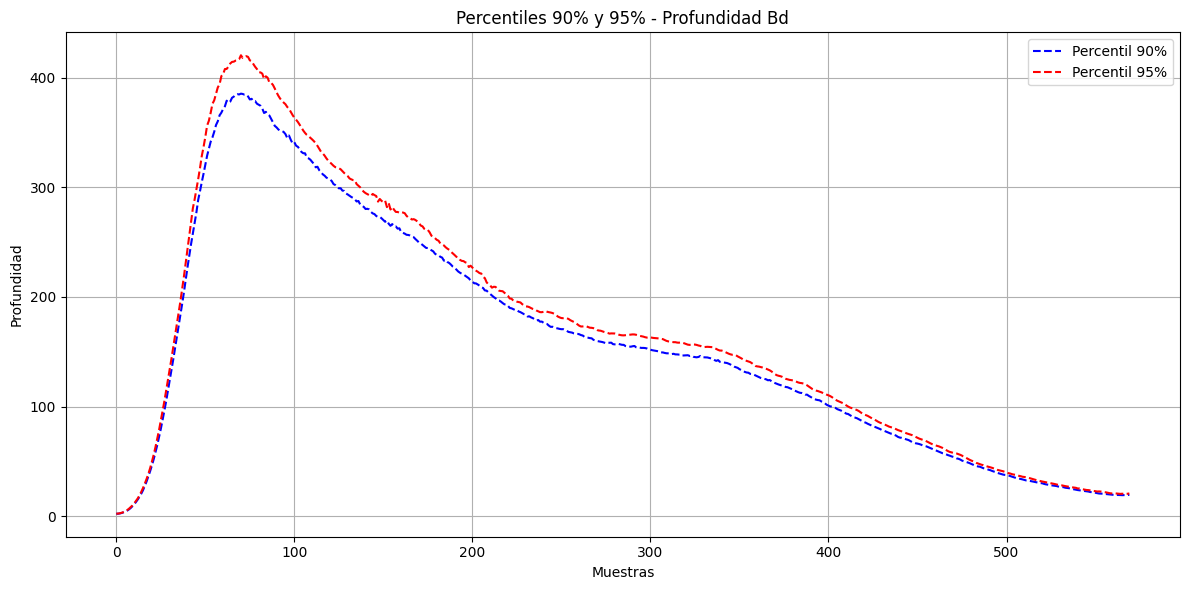

Valores de profundidad ordenados - Método Mbd


0      1      2      3      4      5      6      7      8      9    \
174  1.362  1.439  1.614  1.876  2.189  2.551  3.033  3.726  4.668  5.815   
144  1.462  1.797  1.863  2.483  2.945  3.007  3.613  4.068  4.912  6.689   
78   2.024  2.117  2.277  2.538  2.941  3.516  4.269  5.212  6.386  7.833   
183  1.365  1.445  1.598  1.824  2.124  2.527  3.080  3.813  4.704  5.695   
96   2.079  2.198  2.412  2.761  3.262  3.892  4.627  5.475  6.482  7.715   
43   1.734  1.904  2.129  2.426  2.825  3.367  4.093  5.035  6.202  7.575   
52   1.743  1.888  2.183  2.645  3.234  3.889  4.607  5.478  6.627  8.100   
138  1.529  1.667  1.918  2.315  2.861  3.527  4.268  5.067  5.944  6.945   
27   1.824  2.006  2.313  2.709  3.163  3.705  4.405  5.328  6.501  7.911   
175  1.399  1.476  1.632  1.859  2.154  2.533  3.029  3.665  4.441  5.342   
180  1.989  1.882  1.906  2.129  2.540  3.075  3.680  4.358  5.155  6.111   
65   2.115  2.065  2.121  2.358  2.797  3.392  4.093  4.912  5.915  7.143   
25   2.122  2.153  2.351  2.730  3.247  3.876  4.661  5.678  6.952  8.438   
158  1.452  1.411  1.464  1.722  2.169  3.570  2.911  3.319  5.210  6.077   
22   1.836  2.036  2.395  2.882  3.454  4.125  4.959  5.988  7.185  8.527   
100  2.249  2.330  2.561  2.930  3.398  3.954  4.634  5.509  6.656  8.121   
98   1.642  1.846  2.138  2.532  3.057  3.745  4.602  5.635  6.871  8.334   
181  1.269  1.508  1.783  2.075  2.399  2.791  3.273  3.853  4.547  5.406   
143  1.514  1.655  1.883  2.220  2.676  3.259  3.979  4.830  5.777  6.799   
178  1.723  1.638  1.620  1.738  2.020  2.439  2.950  3.554  4.295  5.205   

     ...     562     563     564     565     566     567     568     569  \
174  ...  15.712  15.364  15.146  15.063  15.070  15.139  15.312  15.672   
144  ...  15.652  16.044  16.044  16.074  17.268  17.211  15.376  15.672   
78   ...  16.231  16.252  16.280  16.320  16.392  16.519  16.751  17.144   
183  ...  15.607  15.488  15.427  15.448  15.538  15.661  15.772  15.848   
96   ...  16.176  16.130  16.258  16.501  16.750  16.876  16.773  16.424   
43   ...  16.413  16.335  16.276  16.220  16.188  16.240  16.438  16.804   
52   ...  16.137  16.129  16.054  15.941  15.900  15.985  16.047  15.816   
138  ...  16.178  16.122  16.134  16.181  16.187  16.185  16.331  16.759   
27   ...  16.060  16.091  16.072  16.111  16.263  16.425  16.424  16.198   
175  ...  16.526  16.405  16.435  16.556  16.617  16.541  16.430  16.450   
180  ...  16.591  16.528  16.421  16.276  16.125  16.002  15.948  15.993   
65   ...  16.268  16.199  16.073  15.990  16.019  16.114  16.116  15.866   
25   ...  16.246  15.890  15.689  15.721  15.980  16.356  16.674  16.796   
158  ...  16.954  16.984  17.875  15.328  16.087  16.912  15.874  16.366   
22   ...  17.130  17.183  17.113  17.008  16.953  16.958  17.018  17.161   
100  ...  16.295  16.342  16.505  16.708  16.874  16.970  17.041  17.168   
98   ...  16.378  16.411  16.468  16.487  16.494  16.537  16.616  16.702   
181  ...  16.897  16.397  16.099  16.144  16.434  16.714  16.705  16.237   
143  ...  16.120  15.983  15.836  15.721  15.659  15.616  15.503  15.260   
178  ...  16.595  16.499  16.396  16.349  16.355  16.338  16.265  16.219   

        570       571  
174  16.221  0.484090  
144  17.251  0.478247  
78   17.677  0.477717  
183  15.905  0.477697  
96   15.916  0.476309  
43   17.301  0.475230  
52   15.179  0.475000  
138  17.422  0.472879  
27   15.850  0.470869  
175  16.646  0.467707  
180  16.126  0.467657  
65   15.351  0.467653  
25   16.705  0.467151  
158  17.390  0.466007  
22   17.398  0.464580  
100  17.381  0.463610  
98   16.775  0.463585  
181  15.372  0.462293  
143  14.920  0.461448  
178  16.294  0.460649  

[20 rows x 572 columns]

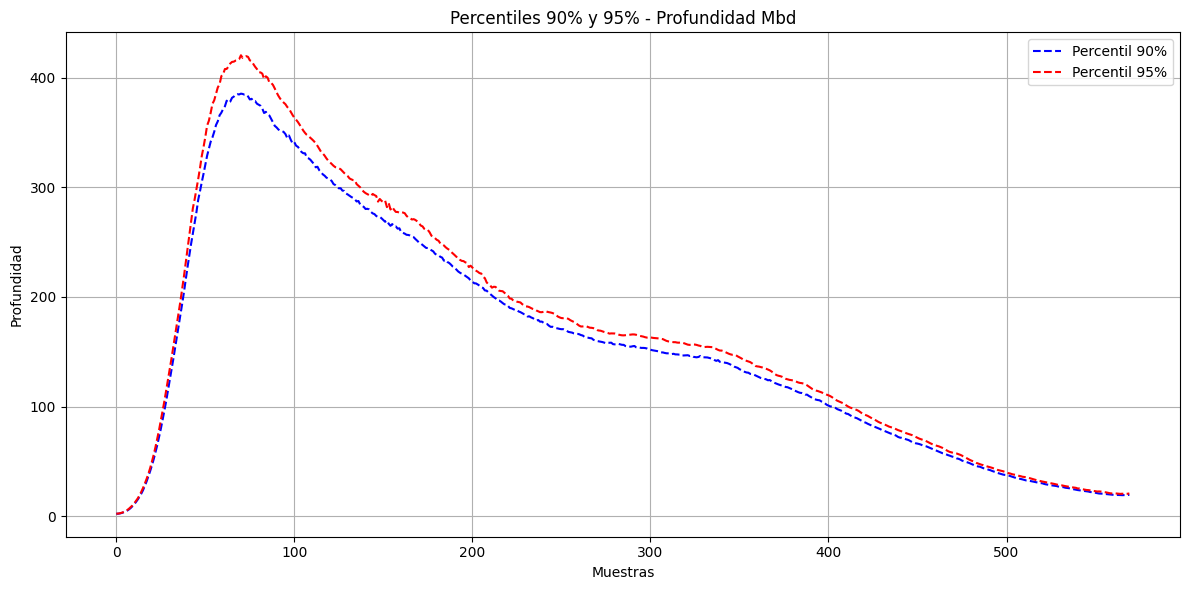

In [49]:
def agregar_valores(data, values, wavelength):
    """
    Agrega un nuevo valor al final de cada fila en la dimensión de wavelength.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - values: Array numpy con dimensiones (268,)
    - wavelength: Índice de la longitud de onda donde se agregará el nuevo valor
    
    Retorna:
    - Nuevo array numpy con valores agregados
    """
    # Crear un nuevo array con un espacio adicional en la dimensión de wavelength
    data_augm = np.zeros((data.shape[0], 
                                      data.shape[1] + 1, 
                                      data.shape[2]))
    
    # Verificar dimensiones
    if values.shape[0] != data.shape[0]:
        raise ValueError("Las dimensiones de 'values' y 'data' no coinciden")
    
    # Copiar los datos originales
    data_augm[:, :data.shape[1], :] = data
    
    # Agregar los valores al final
    for i in range(data.shape[0]):
        data_augm[i, -1, wavelength] = values[i]
    
    return data_augm

def analisis_profundidad_funcional(data, fd, wavelength, metodo='mbd'):
    """
    Realiza análisis de profundidad funcional y genera visualización de percentiles.
    
    Parámetros:
    - data: Array numpy con dimensiones (268, 571, ...)
    - fd: Datos funcionales para cálculo de profundidad
    - wavelength: Índice de la longitud de onda 
    - metodo: 'mbd' (ModifiedBandDepth) o 'bd' (BandDepth)
    
    Retorna:
    - DataFrame con valores de profundidad ordenados
    - Gráfico de percentiles
    """
    # Selección del método de profundidad
    if metodo == 'mbd':
        depth = skfda.exploratory.depth.ModifiedBandDepth()
    elif metodo == 'bd':
        depth = skfda.exploratory.depth.BandDepth()
    else:
        raise ValueError("Método de profundidad no válido. Use 'mbd' o 'bd'")
    
    # Cálculo de valores de profundidad
    values = depth(fd)
    
    # Agregar valores de profundidad al array original
    data_modificado = agregar_valores(data, values, wavelength)
    
    # Crear DataFrame
    df = pd.DataFrame(data_modificado[:,:, wavelength])
    df.sort_values(by=571, axis=0, ascending=False, inplace=True)
    
    # imprime las 10 primeras filas de df
    print(f"Valores de profundidad ordenados - Método {metodo.capitalize()}")
    display(df.head(20))
    
    
    # Cálculo de percentiles
    percentile_90 = df.quantile(0.90)[:570]
    percentile_95 = df.quantile(0.95)[:570]
    
    # Gráfico de percentiles
    plt.figure(figsize=(12, 6))
    plt.plot(percentile_90, label='Percentil 90%', color='blue', linestyle='--')
    plt.plot(percentile_95, label='Percentil 95%', color='red', linestyle='--')
    plt.title(f'Percentiles 90% y 95% - Profundidad {metodo.capitalize()}')
    plt.xlabel('Muestras')
    plt.ylabel('Profundidad')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    return df

df_bd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='bd')
df_mbd = analisis_profundidad_funcional(data, fd_analysis, wavelength_idx, metodo='mbd')


### Boxplot funcional

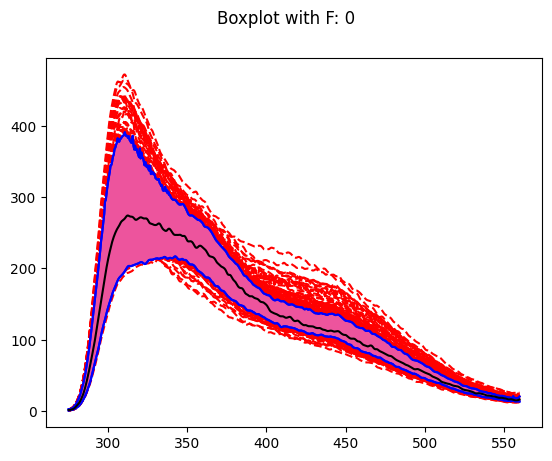

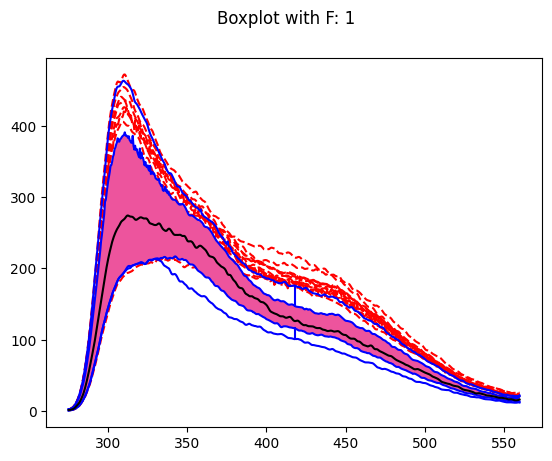

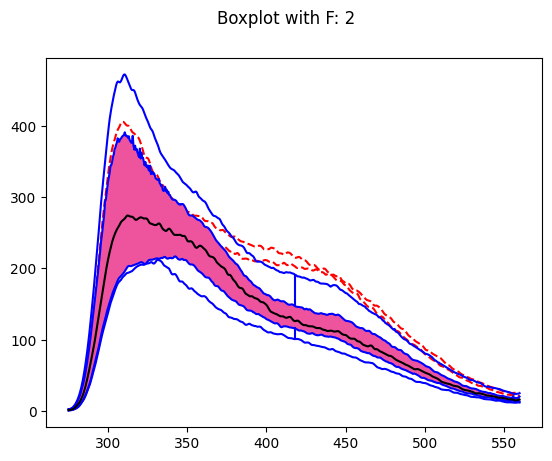

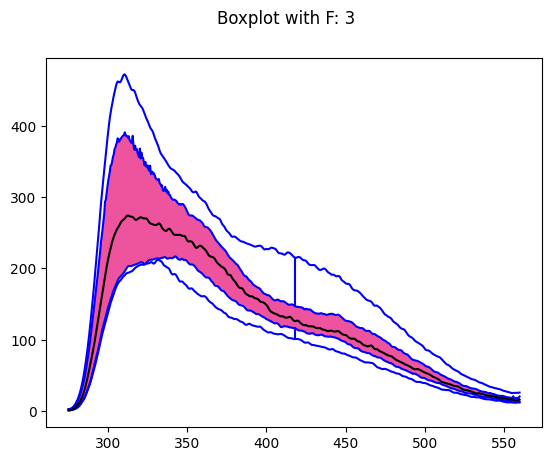

In [61]:
def functional_boxplot(data, wavelength_idx, F=1.5):
    """
    Create functional boxplot with outliers
    """
    
    X = data[:, :, wavelength_idx]
    fd = skfda.FDataGrid(data_matrix=X, grid_points=dominio, dataset_name=f'Boxplot with F: {F}')
    fdBoxplot = Boxplot(fd, factor=F)        
    fdBoxplot.plot()
    
for i in range(4):
    functional_boxplot(data, wavelength_idx, F=i)
